In [30]:
from langgraph.graph import START, END, StateGraph
from langgraph.types import Send
from typing import TypedDict
from openai import OpenAI
from langchain.chat_models import init_chat_model
from typing_extensions import Annotated

import subprocess
import textwrap
import operator

llm = init_chat_model("openai:gpt-4o-mini")

class State(TypedDict):
    video_file: str
    audio_file: str
    transcription: str
    summaries: Annotated[list[str], operator.add]
    

In [ ]:
def extract_audio(state: State):
    output_file = state["video_file"].replace("mp4", "mp3")
    command = [
        "ffmpeg",
        "-i",
        state["video_file"],
        "-filter:a",
        "atempo=2.0", # pay an half
        "-y",
        output_file,
    ]
    subprocess.run(command)
    
    return { "audio_file": output_file }

def transcribe_audio(state: State):
    client = OpenAI()
    with open(state["audio_file"], "rb") as f:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            response_format="text",
            file=f,
            language="ko", # hint to model
            # prompt="Mizaki" # Give hint to model, words list
        )
        
    return { "transcription": transcription }

def dispatch_summarizers(state: State):
    transcription = state["transcription"]
    chunks = []
    for i, chunk in enumerate(textwrap.wrap(transcription, 500)):
        chunks.append({"id": i+1, "chunk": chunk})
    
    return [Send(summarize_chunk.__name__, chunk) for chunk in chunks]

def summarize_chunk(chunk: str):
    chunk_id = chunk["id"]
    chunk = chunk["chunk"]
    
    print(f"Summarizing chunk id : {chunk_id} chunk: {chunk[:100]}\n\n======\n\n")

    response = llm.invoke(f"""
    Please summarize the following text.
    
    Text: {chunk}
    """)
    summary = f"[Chunk {chunk_id}] {response.content}"

    return {"summaries": [summary]}

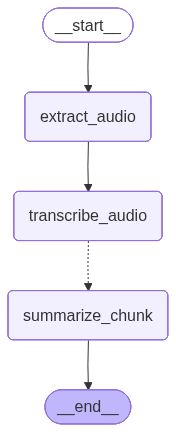

In [24]:
graph_builder = StateGraph(State)

graph_builder.add_node(extract_audio.__name__, extract_audio)
graph_builder.add_node(transcribe_audio.__name__, transcribe_audio)
graph_builder.add_node(summarize_chunk.__name__, summarize_chunk)

graph_builder.add_edge(START, extract_audio.__name__)
graph_builder.add_edge(extract_audio.__name__, transcribe_audio.__name__)
graph_builder.add_conditional_edges(transcribe_audio.__name__, dispatch_summarizers, [summarize_chunk.__name__])
graph_builder.add_edge(summarize_chunk.__name__, END)

graph = graph_builder.compile()

graph

In [25]:
graph.invoke({"video_file": "lifeof20.mp4"})

ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

Summarizing chunk id : 1 chunk: 오늘은 게임 개발자의 정석에 대해 알려드리겠습니다 인생도 게임도 결국 루프인데요 단추 하나라도 잘못 끼우면 에러 폭발 그럼 첫 번째 성적이 정정돼요 연락드립니다 전화주세요 특히 과



Summarizing chunk id : 2 chunk: 커피! 안 마셔요 커피 드세요 커피 아! 바방지에 뭘 산 거야? 아! 아이씨 아! 아! 아 교수님들은 자기 손만 듣는 줄 아시나 봐 수업이 좀 늦었네 벌레도 다 빨고 화장실 청소 



Summarizing chunk id : 3 chunk: 오빠 뭔 일 있어요? 아까부터 계속 딴 생각 하시길래 언니 있나 아니 저는 그 현타가 좀 세게 맞은 날엔 남이 하는 얘기 잘 안 들리고 그러더라고요 그래서 혹시나 똑같이 뭐 그지같



Summarizing chunk id : 4 chunk: 아 진짜요? 아휴 그래도 날씨 좋아져서 다행이다 그러게 땡땡이 쳐보니까 어때요? 마음이 너무 불편한데 아 뭐 수업이나 갈걸 성실한 게 재능인 사람들이야 꼼수를 부리면 안 돼 꼭 이





{'video_file': 'lifeof20.mp4',
 'audio_file': 'lifeof20.mp3',
 'transcription': '오늘은 게임 개발자의 정석에 대해 알려드리겠습니다 인생도 게임도 결국 루프인데요 단추 하나라도 잘못 끼우면 에러 폭발 그럼 첫 번째 성적이 정정돼요 연락드립니다 전화주세요 특히 과제 체크 안 하면 스무 살 첫 단추부터 잘못 그렸어 게임에서 가고 싶으면서 사학과를 왜 가가지고 아 네 교수님 안녕하세요 아 네 다름이 아니라요 네 과제는 똑같이 제출을 했는데 팀원들이랑 근데 저만 뭔가 승인이 안 돼가지고 체크가 안 됐더라고요 어떻게 아 네 아 죄송합니다 교수님 저 D 맞으면은 졸업을 못 해가지고 저 졸업 밀리면 안 돼요 진짜 교수님 죄송합니다 제가 다시 한번 확인을 해보는데 나도 잠 좀 자고 싶다고요 벌써 새벽 4시 자는 것도 내 맘대로 안 되고 등록금, 학원비, 생활비 나 하나 먹여 살리는데도 너무 많은 힘이 든다 140억 황금 매수? 너랑 동갑인데 난 지금까지 뭐 했냐? 뭐 했냐고? 뭐 했냐고? 난 지금까지 뭐 했냐? 주문하신 아메리카노 나왔습니다 주문하신 아메리카노 나왔습니다 에이 커피! 안 마셔요 커피 드세요 커피 아! 바방지에 뭘 산 거야? 아! 아이씨 아! 아! 아 교수님들은 자기 손만 듣는 줄 아시나 봐 수업이 좀 늦었네 벌레도 다 빨고 화장실 청소 다 해놨어 아우 형 이거 내가 할 일인데 아니 그리고 왜 이렇게 발바닥 열심히 하는 거야? 고맙다는 말 한마디가 어렵나? 너 과제할 시간도 없을까 봐 나 간단한 애프터는 다 돈 주고 사서 한다니까 그걸 돈 주고 사? 쓸데없이 성실해봤자 다 자기 손해야 니가 시간이 남아도는 것도 아닌데 그리고 음식도 좀 적당히 뿌려야지 그런가? 근데 형 그거 뭐야? 뭐 먹었어? 아! 쓸데없이 성실해봤자 다 자기 손해야 니가 시간이 남아도는 것도 아닌데 오빠 이거 봐봐 오빠 어? 내 얘기 듣고 있는 거야? 아직 말도 안 했어? 아니 듣고 있었어 수업은 어떻게 하고 여행을 갔어? 당연히

In [9]:
transcription = "오늘은 게임 개발자의 정석에 대해 알려드리겠습니다 인생도 게임도 결국 루프인데요 단추 하나라도 잘못 끼우면 에러 폭발 그럼 첫 번째 성적이 정정돼요 연락드립니다 전화주세요 특히 과제 체크 안 하면 스무 살 첫 단추부터 잘못 그렸어 게임에서 가고 싶으면서 사학과를 왜 가가지고 아 네 교수님 안녕하세요 아 네 다름이 아니라요 네 과제는 똑같이 제출을 했는데 팀원들이랑 근데 저만 뭔가 승인이 안 돼가지고 체크가 안 됐더라고요 어떻게 아 네 아 죄송합니다 교수님 저 D 맞으면은 졸업을 못 해가지고 저 졸업 밀리면 안 돼요 진짜 교수님 죄송합니다 제가 다시 한번 확인을 해보는데 나도 잠 좀 자고 싶다고요 벌써 새벽 4시 자는 것도 내 맘대로 안 되고 등록금, 학원비, 생활비 나 하나 먹여 살리는데도 너무 많은 힘이 든다 140억 황금 매수? 너랑 동갑인데 난 지금까지 뭐 했냐? 뭐 했냐고? 뭐 했냐고? 난 지금까지 뭐 했냐? 주문하신 아메리카노 나왔습니다 주문하신 아메리카노 나왔습니다 에이 커피! 안 마셔요 커피 드세요 커피 아! 바방지에 뭘 산 거야? 아! 아이씨 아! 아! 아 교수님들은 자기 손만 듣는 줄 아시나 봐 수업이 좀 늦었네 벌레도 다 빨고 화장실 청소 다 해놨어 아우 형 이거 내가 할 일인데 아니 그리고 왜 이렇게 발바닥 열심히 하는 거야? 고맙다는 말 한마디가 어렵나? 너 과제할 시간도 없을까 봐 나 간단한 애프터는 다 돈 주고 사서 한다니까 그걸 돈 주고 사? 쓸데없이 성실해봤자 다 자기 손해야 니가 시간이 남아도는 것도 아닌데 그리고 음식도 좀 적당히 뿌려야지 그런가? 근데 형 그거 뭐야? 뭐 먹었어? 아! 쓸데없이 성실해봤자 다 자기 손해야 니가 시간이 남아도는 것도 아닌데 오빠 이거 봐봐 오빠 어? 내 얘기 듣고 있는 거야? 아직 말도 안 했어? 아니 듣고 있었어 수업은 어떻게 하고 여행을 갔어? 당연히 짰지 두 번까지는 괜찮아 몰랐거든? 야 여기 가야 된다 수업 가야 돼 아휴 괜찮아 괜찮아 그럼 가 가? 아 나는 수업 때까지 시간도 남아서 아 오빠 뭔 일 있어요? 아까부터 계속 딴 생각 하시길래 언니 있나 아니 저는 그 현타가 좀 세게 맞은 날엔 남이 하는 얘기 잘 안 들리고 그러더라고요 그래서 혹시나 똑같이 뭐 그지같애 아 아 미안 아 내가 제일 싫어하는 게 힘 빠진 소리 하는 건데 아 에이 오빠 똑부러져서 나랑 완전 다를 줄 알았는데 되게 친근한데요? 그래? 근데 그지 맞아 요즘에 개근버지라고 말 알지 초 중고 대학교 때까지 내가 16년을 개근했거든 그게 옛날에는 뭔가 되게 성실하다는 칭찬이었는데 요즘에는 그냥 해외여행 못 가는 거짓이 오빠인데 에이 그런 말 어딨어요 난 좀 다른 의미긴 한데 아 그 남들 출퇴하고 놀러 다닐 때 나도 좀 땡땡이 좀 쳐볼 걸 아 갑자기 억울하네 에이 저도 안 억울해요 오빠 욕망이 스토커 비워서 땡땡이 치는 거 맞아요? 그렇긴 한데 남들이 즉흥여행 가는 건 있어 보이던데 아 난 진짜 그지같애 다치기 때가 아니나 보죠 어 어 막내 막내 막내 막내 뭐야 무슨 일인데 근처 카페가 다 닫아가지고 아 진짜요? 아휴 그래도 날씨 좋아져서 다행이다 그러게 땡땡이 쳐보니까 어때요? 마음이 너무 불편한데 아 뭐 수업이나 갈걸 성실한 게 재능인 사람들이야 꼼수를 부리면 안 돼 꼭 이래 응 꼭 이래 제가 인스타에서 봤는데 무기력하고 힘이 없다 잠이 잘 안 온다 담당할 수 없는 힘든 일들이 생긴다 다 잘될 거라는 증거예요 다 잘되려고 이러는 거겠지 무조건이죠 이 시기가 무사히 지나가게 해주세요 그냥 그렇다면 멤버십에 관여하시면 짧은 대본 스크린 오프 박범 안에서를 검색하실 수 있습니다 다 되네 근데 퇴근 시간이니까 꼭 퇴근식이겠지\n"

import textwrap

for i, chunk in enumerate(textwrap.wrap(transcription, width=500)):
    print(f"Chunk ID : {i}: {chunk}")
    print("=====")

Chunk ID : 0: 오늘은 게임 개발자의 정석에 대해 알려드리겠습니다 인생도 게임도 결국 루프인데요 단추 하나라도 잘못 끼우면 에러 폭발 그럼 첫 번째 성적이 정정돼요 연락드립니다 전화주세요 특히 과제 체크 안 하면 스무 살 첫 단추부터 잘못 그렸어 게임에서 가고 싶으면서 사학과를 왜 가가지고 아 네 교수님 안녕하세요 아 네 다름이 아니라요 네 과제는 똑같이 제출을 했는데 팀원들이랑 근데 저만 뭔가 승인이 안 돼가지고 체크가 안 됐더라고요 어떻게 아 네 아 죄송합니다 교수님 저 D 맞으면은 졸업을 못 해가지고 저 졸업 밀리면 안 돼요 진짜 교수님 죄송합니다 제가 다시 한번 확인을 해보는데 나도 잠 좀 자고 싶다고요 벌써 새벽 4시 자는 것도 내 맘대로 안 되고 등록금, 학원비, 생활비 나 하나 먹여 살리는데도 너무 많은 힘이 든다 140억 황금 매수? 너랑 동갑인데 난 지금까지 뭐 했냐? 뭐 했냐고? 뭐 했냐고? 난 지금까지 뭐 했냐? 주문하신 아메리카노 나왔습니다 주문하신 아메리카노 나왔습니다 에이
=====
Chunk ID : 1: 커피! 안 마셔요 커피 드세요 커피 아! 바방지에 뭘 산 거야? 아! 아이씨 아! 아! 아 교수님들은 자기 손만 듣는 줄 아시나 봐 수업이 좀 늦었네 벌레도 다 빨고 화장실 청소 다 해놨어 아우 형 이거 내가 할 일인데 아니 그리고 왜 이렇게 발바닥 열심히 하는 거야? 고맙다는 말 한마디가 어렵나? 너 과제할 시간도 없을까 봐 나 간단한 애프터는 다 돈 주고 사서 한다니까 그걸 돈 주고 사? 쓸데없이 성실해봤자 다 자기 손해야 니가 시간이 남아도는 것도 아닌데 그리고 음식도 좀 적당히 뿌려야지 그런가? 근데 형 그거 뭐야? 뭐 먹었어? 아! 쓸데없이 성실해봤자 다 자기 손해야 니가 시간이 남아도는 것도 아닌데 오빠 이거 봐봐 오빠 어? 내 얘기 듣고 있는 거야? 아직 말도 안 했어? 아니 듣고 있었어 수업은 어떻게 하고 여행을 갔어? 당연히 짰지 두 번까지는 괜찮아 몰랐거든? 야 여기 가야 된다 수업 가야 돼 아휴 괜찮아 